In [1]:
import lucem_illud_2020 

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.cm #Still for graphics
import matplotlib #Still for graphics
import matplotlib.pyplot as plt #For graphics
import seaborn as sns #Makes the graphics look nicer

import itertools
import json
import pandas as pd
import networkx as nx
from tools import *
from gensim.matutils import kullback_leibler

from nltk.stem import PorterStemmer
import spacy
import nltk
nlp = spacy.load("en")

import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

%matplotlib inline

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
For my final project, I plan to study how different policy think tanks contribute differently to the formation of political ideology in the United States. 
 
In this research, I plan to  
* 1) web-scrape articles written by influential policy think tanks. The sample includes but is not limited to the Brookings Institute and Center for American Progress (liberal) as well as the Heritage Foundation and the American Enterprise Institute (conservative). I plan to also limit the scope of time to 2009-present.
* 2) analyzea the change of their advocacy strategies (whether they choose to focus on topics/ ideology/ presidency, etc.). This means that at the very least I need to project the articles into certain topic dimensions.
* 3) Particularly, I am interested in assessing the tensions between think tanks who are both liberal/ conservative.  This means analyzing which topics each think tank focuses on and the keywords they use to frame their interested issues. 
* 4) Potentially, I will also examine how the Congress legislation corresponds to these advocacy strategies, based on the bills I have web-scrapped before from the Congress.gov. More specifically, this means matching whether a think tank's increased in a particular policy actually pushes certain related legislation.

## ***Why?***
* I am particularly motivated by my previous experience working in a conservative think tank at D.C. (namely, the American Enterprise Institute), where I recognized a historical tension between social and economic conservatists within the Republican party. This personal feeling echoes with multiple qualitative research I read later as well as my conversations with my conservative friends.   
* However, it seems to me that most computational social science research focuses on depicting the salient inter-party heterogeneity between Democrats and Republicans. There is a lack of quantitative research in assessing the level of ideological heterogeneity within each party as well as how this heterogeneity is formed. The fact that most quantitative political research categorizes human agents into a binary, liberal-or-conservative dimension, may reinforce the narratives which frame polarization even furthur.  
* Recognizing the importance of this ideological nuances, I hope to quantitively study this issue. I put a particular interest on policy think tanks, because they provide a great showcase of how policy ideas are framed and come into being within certain ideological contexts.

## ***How?***
* Semantic Influence Network: Compare the semantic influence networks of the corpus from different think tanks and (maybe) different period of time to see what they frame as priorities and how they frame the noun-ideas.
* Language Pattern: Use methods such as DL divergence to   
1) compare the writing style of different think tanks.   
2) compare how think tanks address the same topics (say, immigration) with different focuses.
* Top Modeling and unsupervised clustering: Cluster and generate topics from each think tank's corpus to see whether there is a clear pattern of different policy combinations: For example, the hypothesis may be that the Heritage Foundation focuses more on religion and national defense and the American Enterprise Institute focueses more on economic policy and immigration.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which?***
* I plan to gather all articles from 2009 to present (Obama and Trump) published by the Brookings Institute and Center for American Progress (liberal) as well as the Heritage Foundation and the American Enterprise Institute (conservative). I hope that the four influential think tanks can represent the leading liberal and conservative opinions among lobbists and policy researchers in the past decade. However, a central limitation is that, compared to these four comprehensive think tanks, there are smaller, more issue-driven think tanks that are considerablly influential in a particular field of policy.    
* In terms of analyzing the ideological nuances mentioned above, I might instead focus on legislative bills or politicians' social media. But since think tanks are rarely analyzed quantitatively by scholars, I hope to start with this perspective and proceed forward when needed. To scale up my sample, I may gather even older articles and articles from more think tanks. But since the definition of think tank is itself vague--whether a think tank has to be a nonprofit organization, for example, I need to clarify my definitions before scaling up.    

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

* The words with the highest tf-idf (excluding numbers) are "spent", "fees", and "ensure"--seems to be associated with appropriations. 
* In general, the high tf-idf words tend to center around topics about business, abortion, Florida, appropriation, etc. 
* As calculated by `plotSilhouette`, from `n_clusters = 3` to `n_clusters = 9`, The average silhouette_score keeps increasing. That is, `n_clusters = 8` and `n_clusters = 9` get the best scores.
* By observation, when k>=4, we can at least group the four significantly different branches. Based on the KMeans with numClusters = 4, we know that the four branches are about `family and school`, `Trump, Iran, Religion, China, etc`, `workers and budget`, `impeachment and Congress`, that is, except Cluster 1 which has relatively heterogenous information, Cluster 0, 2, and 3 convey clear and united information.
* KMeans with numClusters = 9, however, also gives quite clear information per cluster: `family and education`, `abortion`, `Middle East and national defense`, `impeachment`, `supreme court and religion`, `China and trade war`, `labor's rights`, `congress spending`, `taxes and business growth`. 

In [2]:
heritage_data = pd.read_csv('heritage_text_cleaned.csv')
heritage_data.dropna(subset=['text'], inplace=True)

In [3]:
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                                 max_features=1000, min_df=3, 
                                                                 stop_words='english', 
                                                                 norm='l2')
groupsTFVects = ngTFVectorizer.fit_transform(heritage_data['text'])
print(groupsTFVects.shape)

(325, 1000)


In [4]:
# tf-idf for each word in each text
list(zip(ngTFVectorizer.vocabulary_.keys(), groupsTFVects.data))[:20]

[('spent', 0.05158541250287484),
 ('25', 0.04207039978882941),
 ('000', 0.04695274151454691),
 ('fees', 0.04695274151454691),
 ('ensure', 0.049103056281715234),
 ('laws', 0.0335984911928249),
 ('united', 0.03302330719328288),
 ('states', 0.051144194766401196),
 ('writes', 0.04309318410608658),
 ('born', 0.04042335848034068),
 ('legal', 0.09324140012111123),
 ('life', 0.052039060529417216),
 ('small', 0.065683470773111),
 ('business', 0.05348212454875313),
 ('called', 0.04629536697574464),
 ('south', 0.058114795537081064),
 ('florida', 0.03665203931996783),
 ('left', 0.05880015173363526),
 ('late', 0.03775042678071411),
 ('spending', 0.055067348353365714)]

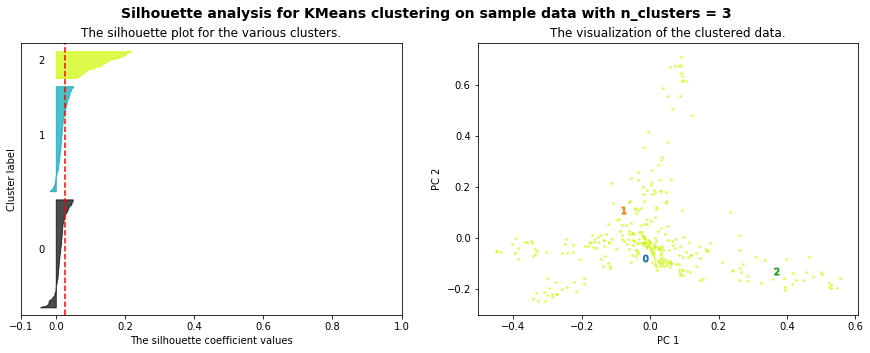

For n_clusters = 3, The average silhouette_score is : 0.027


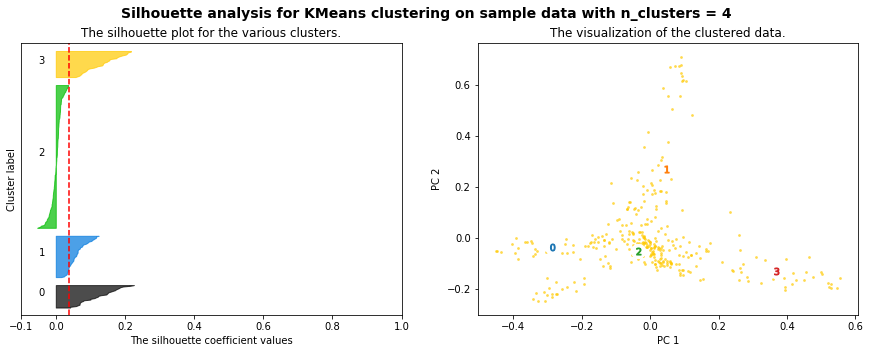

For n_clusters = 4, The average silhouette_score is : 0.039


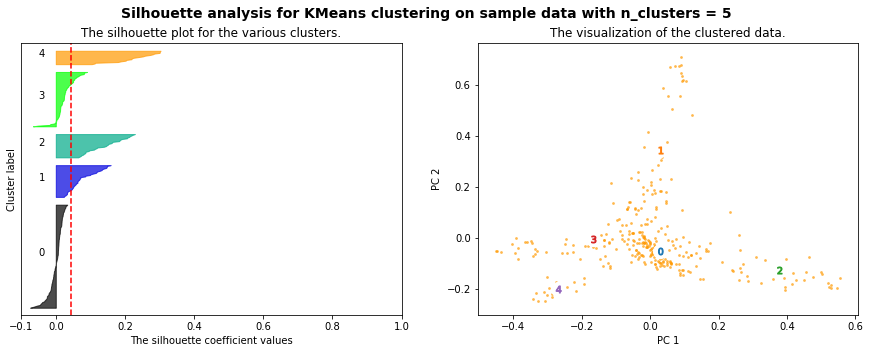

For n_clusters = 5, The average silhouette_score is : 0.045


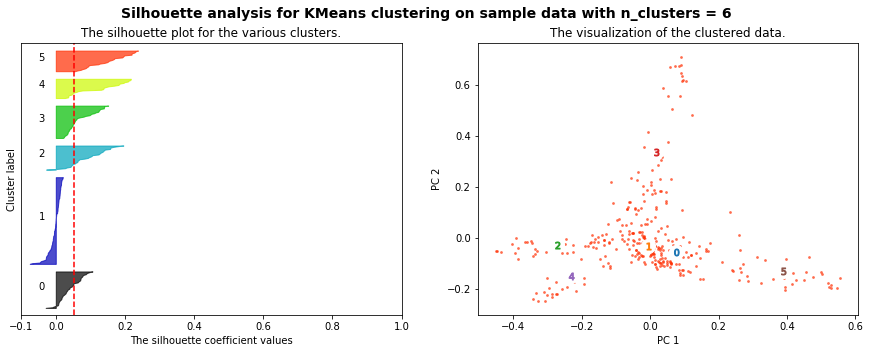

For n_clusters = 6, The average silhouette_score is : 0.052


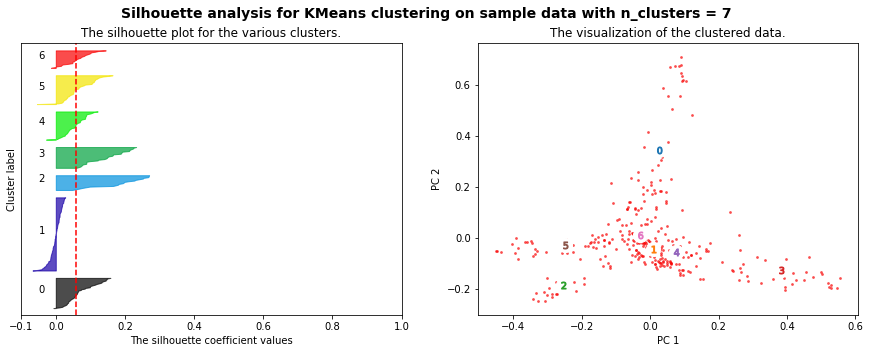

For n_clusters = 7, The average silhouette_score is : 0.059


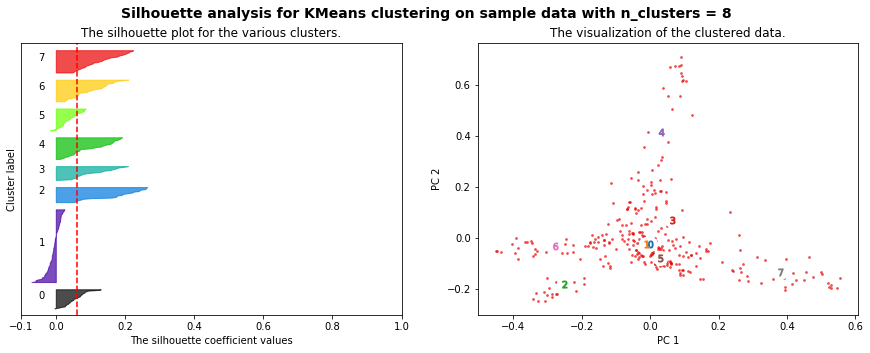

For n_clusters = 8, The average silhouette_score is : 0.063


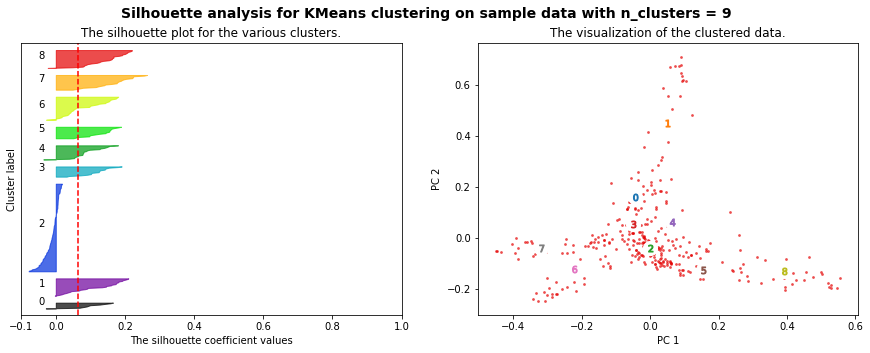

For n_clusters = 9, The average silhouette_score is : 0.063


In [5]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(groupsTFVects.toarray())
reduced_data = pca.transform(groupsTFVects.toarray())

X = groupsTFVects.toarray()
for n in range(3, 10): plotSilhouette(n, X, groupsTFVects)

In [6]:
colordict = {0:'yellow', 1:'blue', 2:'red', 3:'green', 4:'grey', 
             5: 'red', 6: 'purple', 7: 'black', 8:'brown'}

  Cluster 0: Cluster 1:   Cluster 2: Cluster 3:
0        tax      court         iran     school
1    workers  religious        trump   students
2    percent        law  impeachment    schools
3      taxes       life        china  education
4    pension      union        house   children
5     growth    supreme      chinese    charter
6     budget    justice      ukraine    parents
7       cuts      women      iranian    student
8     income     county     military     public
9      labor       says     security   families


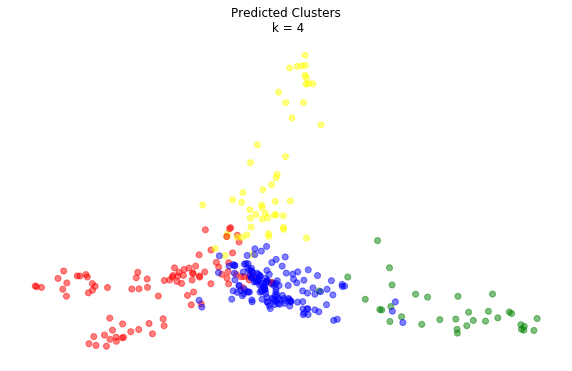

In [7]:
numClusters = 4
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(groupsTFVects)
heritage_data['kmeans_predictions'] = km.labels_

#Top terms per cluster:
terms = ngTFVectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
table = pd.DataFrame()
for i in range(numClusters):
    table[f"Cluster {i}:"] = [terms[ind] for ind in order_centroids[i, :10]]
print(table)

colors_p = [colordict[i] for i in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(()); plt.yticks(())
plt.title(f'Predicted Clusters\n k = {len(set(km.labels_))}')
plt.show()

In [8]:
numClusters = 9
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(groupsTFVects)
heritage_data['kmeans_predictions'] = km.labels_

#Top terms per cluster:
terms = ngTFVectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
table = pd.DataFrame()

for i in range(numClusters):
    table[f"Cluster {i}:"] = [terms[ind] for ind in order_centroids[i, :10]]
table

,Cluster 0:,Cluster 1:,Cluster 2:,Cluster 3:,Cluster 4:,Cluster 5:,Cluster 6:,Cluster 7:,Cluster 8:
0,species,school,iran,union,trump,religious,china,tax,women
1,endangered,students,iranian,workers,impeachment,court,chinese,taxes,life
2,wildlife,education,iraq,pension,house,supreme,trade,percent,law
3,fish,schools,regime,employees,ukraine,justices,tariffs,growth,news
4,property,charter,yemen,unions,russian,case,hong,cuts,caller
5,threatened,children,saudi,janus,russia,freedom,kong,spending,county
6,act,parents,suleimani,work,senate,program,farmers,income,criminal
7,critical,student,nuclear,court,afghanistan,religion,agricultural,budget,transgender
8,service,public,deal,labor,epa,schools,world,economic,says
9,federal,families,iranians,dues,trial,constitution,communist,americans,daily


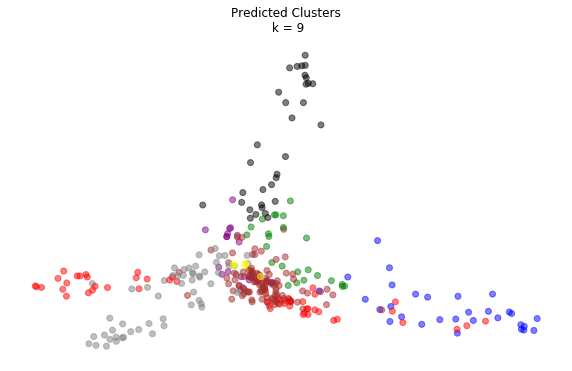

In [9]:
colors_p = [colordict[i] for i in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(()); plt.yticks(())
plt.title(f'Predicted Clusters\n k = {len(set(km.labels_))}')
plt.show()

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

* I start with the dendrogram for the first 100 texts: the tree is colored to show the clusters based on their 'distance' from one another. 
* With `fcluster()`, I cut the tree into 4 clusters. This cluster result is quite different from the kMeans cluster result (V-measure = 0.455)
* As shown by the figure, fcluster emphasizes to cluster center points together while KMeans tend to assign the center points to different clusters. This means fcluster clusters the extreme points more accurately but leaves the ambiguous ones in the same central cluster. 
* Silhouette Score identifies that the best number of clusters is 9: too many clusters I guess. This is probably because the topic of my corpus do not have a well-defined tree-like structure.

In [10]:
numClusters = 4
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(groupsTFVects)
heritage_data['kmeans_predictions'] = km.labels_
heritage_data.head()

,text,from,kmeans_predictions
0,"""We have spent over $25,000 in fees to ensure ...",heritage,1
1,Thousands of pro-lifers move down the streets ...,heritage,1
2,Volunteers paint over a wall covered in graffi...,heritage,1
3,Then-U.S. Supreme Court nominee Clarence Thoma...,heritage,1
4,White House counsel Pat Cipollone arrives Tues...,heritage,3


In [11]:
groupsCoocMat = groupsTFVects * groupsTFVects.T
groupsCoocMat.setdiag(0)
linkage_matrix = scipy.cluster.hierarchy.ward(groupsCoocMat[:100, :100].toarray())

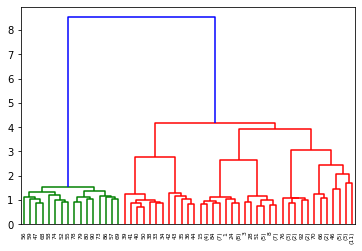

In [12]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=6, truncate_mode='level')

In [13]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(groupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 
                                                             4, 'maxclust')

print("For our heritage corpus clusters (compare KMeans and Hierarchical clusters):")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(heritage_data['kmeans_predictions'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(heritage_data['kmeans_predictions'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(heritage_data['kmeans_predictions'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(heritage_data['kmeans_predictions'], hierarchicalClusters_full)))

For our heritage corpus clusters (compare KMeans and Hierarchical clusters):
Homogeneity: 0.408
Completeness: 0.641
V-measure: 0.499
Adjusted Rand Score: 0.447


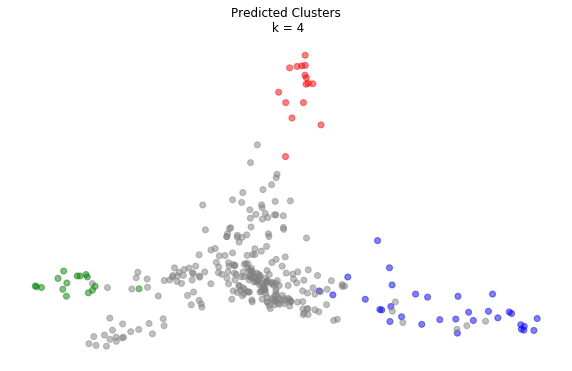

In [14]:
#heritage_data['kmeans_predictions'] = km.labels_
#heritage_data['hierarchical_predictions'] = hierarchicalClusters_full
colors_p = [colordict[i] for i in hierarchicalClusters_full]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(()); plt.yticks(())
plt.title(f'Predicted Clusters\n k = {len(set(hierarchicalClusters_full))}')
plt.show()

best number of clusters is 9


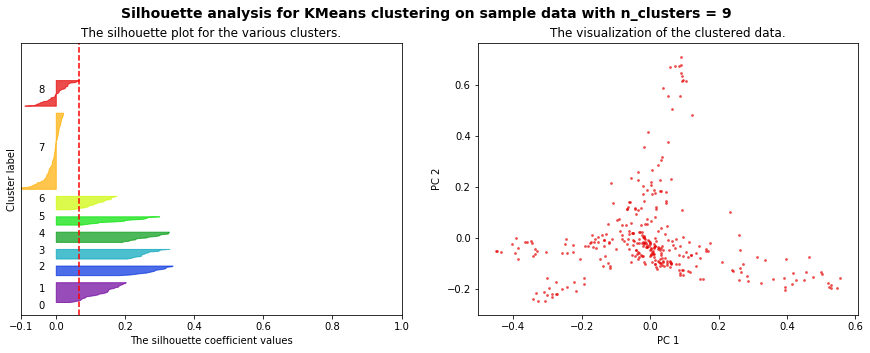

For n_clusters = 9, The average silhouette_score is : 0.066


In [15]:
#X = groupsTFVects.toarray()
CoocMat = groupsTFVects * groupsTFVects.T
CoocMat.setdiag(0)
linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())

silhouette_avg = []
for i in range(3, 10):
    cluster_labels = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, i, 'maxclust')
    silhouette_avg.append(sklearn.metrics.silhouette_score(groupsTFVects.toarray(), 
                                                           cluster_labels))
    
best_num_clusters = silhouette_avg.index(max(silhouette_avg)) + 3
print(f'best number of clusters is {best_num_clusters}')

plotHierchySilhouette(best_num_clusters, groupsTFVects)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

* Looking at the 6 topics in `wordRanksDF`, the information is not as clear as we observe in KMeans. It seems that Topic 0 is about a range of topics from Iran to Tax, Topic 1 is about family and education, Topic 2 is again about Tax and more about religion, Topic 3 is again about family and education, Topic 4 is about impeachment but also about unions, and Topic 5 is about Iran and school. It is hard to summarize semantic meanings from such a topic model structure.
* Comparing the topic model for each document with the results with a manual summary, it seems that `text[2]` is strongly related to `topic#5` and `text[3]` is strongly related to `topic#3`. `text[2]` is about church and `text[3]`is strongly related to Supreme Court nominee Clarence Thomas. It is, however, hard to observe this pattern from the list of top words from each topic. 
* Changing $\eta$ and $\alpha$ does not help make the semantic meanings of the five topics any clearer. In general, changing $\alpha$ from `asymmetric` to `auto` increases the density of the first element but does not change much of the rest: the same effect applies to decreasing $\eta$ from 0.9 to 0.00001 as well.

In [16]:
heritage_data['tokenized_text'] = heritage_data['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
heritage_data['normalized_tokens'] = heritage_data['tokenized_text'].apply(lambda x: 
                                                    lucem_illud_2020.normalizeTokens(x))
heritage_data['id'] = range(heritage_data.shape[0])

In [17]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

heritage_data['reduced_tokens'] = heritage_data['normalized_tokens'].apply(lambda x: 
                                dropMissing(x, ngTFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(heritage_data['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in heritage_data['reduced_tokens']]

In [18]:
num_topics=6

In [19]:
gensim.corpora.MmCorpus.serialize('heritage.mm', corpus)
senmm = gensim.corpora.MmCorpus('heritage.mm')
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                         num_topics=num_topics, alpha='auto', eta='auto')

In [20]:
ldaDF = pandas.DataFrame({
        'name' : heritage_data['id'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in heritage_data['reduced_tokens']]})

topicsProbDict = {i:[0] * len(ldaDF) for i in range(senlda.num_topics)}

for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [21]:
N = 10
ldaDFV = ldaDF[:N][['topic_%d' %x for x in range(num_topics)]]
ldaDFVisN = ldaDF[:N][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0.140509,0.000000,0.129485,0.046721,0.000000,0.680242
1,0.000000,0.942649,0.010718,0.013068,0.010829,0.012759
2,0.000000,0.588372,0.000000,0.078096,0.000000,0.332293
3,0.000000,0.799622,0.042209,0.156746,0.000000,0.000000
4,0.000000,0.000000,0.536217,0.460674,0.000000,0.000000
5,0.000000,0.199995,0.000000,0.000000,0.000000,0.786186
6,0.000000,0.376865,0.617658,0.000000,0.000000,0.000000
7,0.000000,0.055012,0.151775,0.469646,0.000000,0.316402
8,0.000000,0.093190,0.000000,0.052454,0.033078,0.812009
9,0.000000,0.000000,0.070986,0.915620,0.000000,0.000000


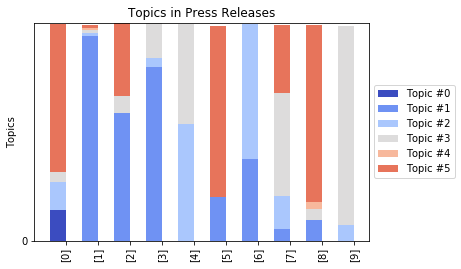

In [22]:
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  
           bbox_to_anchor = (1, .5))

plt.show()

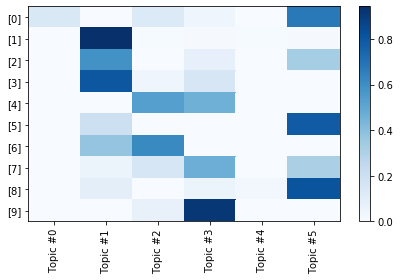

In [23]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [24]:
#print(heritage_data['text'][0]) ## comments on topics from immigration to school
#print(heritage_data['text'][1]) ## pro_life march
#print(heritage_data['text'][2]) ## church life
#print(heritage_data['text'][3]) ## Supreme Court nominee Clarence Thomas
#print(heritage_data['text'][4]) ## impeachment
#print(heritage_data['text'][5]) ## the death of a conservative thinker
#print(heritage_data['text'][6]) ## border control and Israel
#print(heritage_data['text'][7]) ## homelessness in San Francisco
#print(heritage_data['text'][8]) ## anti-communist, anti-union, workers, etc
#print(heritage_data['text'][9]) ## impeachment

In [25]:
#the top words from each topic to get a sense 
#of the semantic (or syntactic) domain they represent
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,say,say,say,say,school,school
1,work,court,trump,trump,tax,say
2,court,law,court,school,say,tax
3,right,right,case,right,education,trump
4,trump,supreme,law,law,policy,family
5,law,iran,house,house,high,child
6,iran,case,work,policy,student,american
7,religious,think,know,union,religious,union
8,union,life,federal,think,court,law
9,rule,trump,impeachment,county,child,right


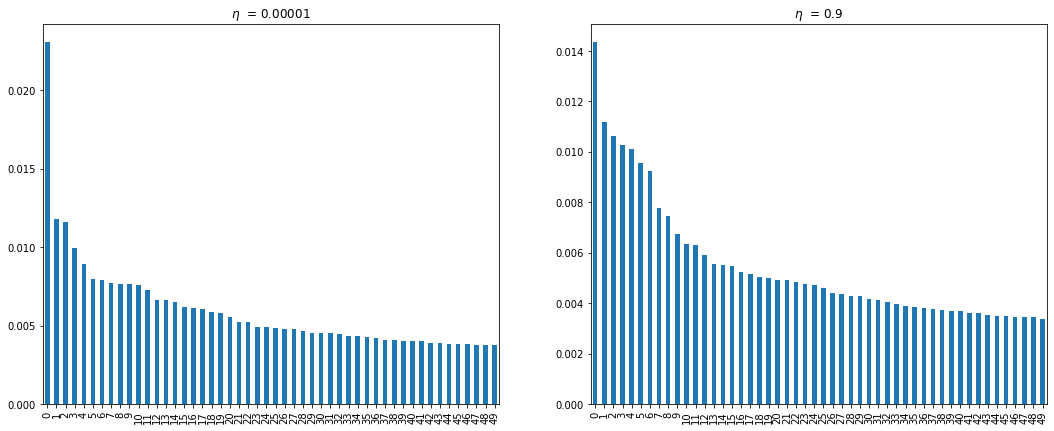

In [26]:
### changing eta
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, eta = 0.9)

topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

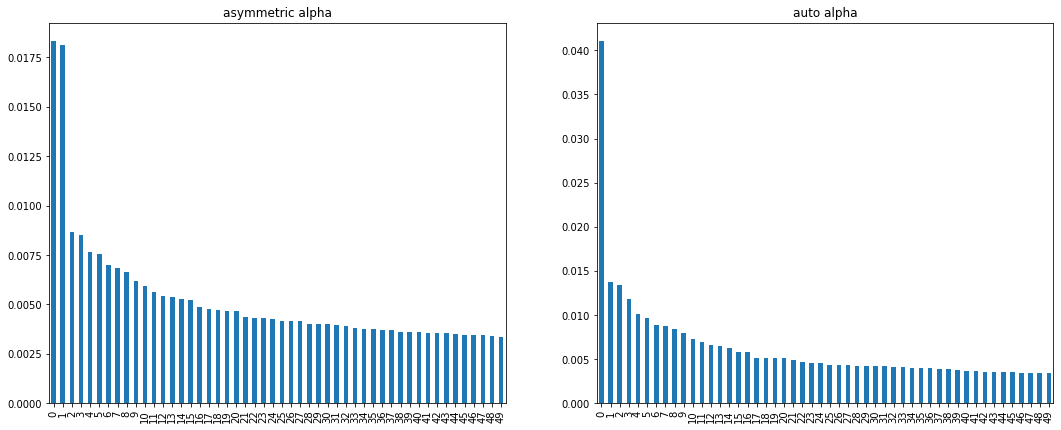

In [27]:
### changing alpha
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, alpha = "asymmetric")
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=10, alpha = "auto")

topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'asymmetric alpha')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'auto alpha')
plt.show()

In [28]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=5, eta = 0.0001)
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,trump,say,say,say,school
1,say,iran,school,law,say
2,tax,trump,union,union,student
3,impeachment,house,public,right,policy
4,policy,country,work,work,right
5,court,case,child,court,law
6,house,law,right,religious,court
7,law,force,court,school,trump
8,american,world,county,federal,work
9,think,right,know,case,rule


In [29]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=5, eta = 0.9)
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,say,say,say,say,say
1,trump,school,policy,iran,tax
2,school,union,school,court,school
3,union,right,house,school,trump
4,work,law,woman,trump,law
5,county,court,trump,think,child
6,like,trump,court,case,work
7,case,work,law,supreme,high
8,house,case,like,right,student
9,right,public,force,law,federal


In [30]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=5, alpha = "asymmetric")
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,say,say,school,say,say
1,school,trump,say,law,trump
2,union,house,student,case,work
3,law,know,policy,union,right
4,work,work,court,court,law
5,right,family,program,school,house
6,trump,law,education,trump,impeachment
7,pay,american,right,public,tax
8,come,tax,woman,iran,policy
9,court,court,think,life,county


In [31]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, 
                                          num_topics=5, alpha = "auto")
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,say,say,school,tax,say
1,school,trump,say,say,trump
2,trump,school,union,school,right
3,house,law,court,religious,law
4,impeachment,come,law,law,like
5,work,like,right,american,know
6,court,public,policy,policy,work
7,right,work,public,iran,student
8,case,tax,iran,trump,school
9,justice,country,child,america,report



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

* To save time I simply ran the code in the original notebook and generated `soup_df.csv` with all words already tokenized. Here I simply reloaded it and re-formatted it.
* Because my corpus does not have actor-specific information (maybe I will have it later), I focus on another soup opera called *Bold and Beautiful* and analyze the actors who appears over 1000 times as interacting with others.
* As shown in the heat map and the network graph, most of the interactions happen between Brooke and Ridge and they are also at the center of other person’s social interaction. This makes sense because Ridge and Brooke have been married for over twenty years and are the main characters in this opera. They are at the center also because they are the parents of the rest of the important characters: Rick, Bridget, Hope, R.J. and Jack.
* It is hard to tell what the topics are about what and it seems that the topic models are mostly featured by different names.
* I also exclude some of the less interesting word types and include only the stemized words. In the original model, Hope is the one who is significantly different from others' style. In the new model which emphasizes on meaningful words, Donna becomes the one who is significantly different from others' style. 

In [32]:
soap_df = pd.read_csv('soup_df.csv')
## Bold and Beautiful
dool = soap_df['Tokenized Texts'][2].strip('[').strip(']').split(', ')
dool = [i.strip('\'').strip('\"') for i in dool]
' '.join(dool[0:150])

"@!Bridget What did you say @!Deacon Just forget I said it @!Bridget You want to get married @!Amber Oh how did I ever let Deacon talk me into this @(Amber sighs @!Amber How am I gon na explain it to Rick I 'm not not today The last thing he needs to hear on his wedding day is that Deacon and I have matching tattoos @(Door opens @!Rick Eric 's with Helen He 's doin great Wow @!Amber You like @!Rick What did I ever do to deserve this @!Amber You married me @!Rick Brilliant idea @!Amber You still think so after what happened today @!Rick God can you believe Bridget She 's always been so sensible How could she get mixed up with a loser like Deacon @(Amber sighs @!Amber I do n't know Deacon 's pretty persuasive @!Rick Yeah well at least we put an end to it"

In [33]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1
len(characters)

613

In [34]:
actor_network = nx.Graph()
for character in characters:
    if characters[character] > 1000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
print(len(actor_network.nodes.data()))
actor_network.nodes.data()

14


NodeDataView({'Bridget': {'lines_spoken': 2181, 'words': []}, 'Rick': {'lines_spoken': 1516, 'words': []}, 'Brooke': {'lines_spoken': 4706, 'words': []}, 'Eric': {'lines_spoken': 1902, 'words': []}, 'Stephanie': {'lines_spoken': 3098, 'words': []}, 'Ridge': {'lines_spoken': 3314, 'words': []}, 'Jackie': {'lines_spoken': 1259, 'words': []}, 'Taylor': {'lines_spoken': 1688, 'words': []}, 'Steffy': {'lines_spoken': 1201, 'words': []}, 'Nick': {'lines_spoken': 2651, 'words': []}, 'Hope': {'lines_spoken': 1132, 'words': []}, 'Donna': {'lines_spoken': 1085, 'words': []}, 'Katie': {'lines_spoken': 1143, 'words': []}, 'Sighs': {'lines_spoken': 1634, 'words': []}})

In [35]:
i = 0
all_texts = []
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

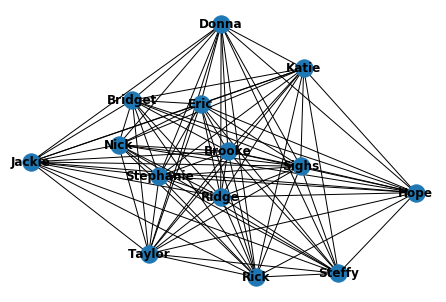

In [36]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [37]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, 
                                          num_topics=10, 
                                          alpha='auto', eta='auto')
doollda.show_topics()

[(0,
  '0.064*"yes" + 0.059*"thank" + 0.038*"leave" + 0.033*"hope" + 0.032*"let" + 0.032*"hey" + 0.029*"stop" + 0.027*"bill" + 0.026*"work" + 0.021*"know"'),
 (1,
  '0.100*"na" + 0.100*"gon" + 0.055*"right" + 0.042*"m" + 0.036*"feel" + 0.031*"wedding" + 0.031*"wait" + 0.021*"ask" + 0.021*"know" + 0.017*"mind"'),
 (2,
  '0.181*"oh" + 0.072*"happen" + 0.050*"think" + 0.044*"go" + 0.040*"god" + 0.019*"nick" + 0.017*"stephanie" + 0.016*"hope" + 0.013*"divorce" + 0.012*"mean"'),
 (3,
  '0.078*"come" + 0.028*"know" + 0.025*"see" + 0.023*"liam" + 0.021*"find" + 0.018*"walk" + 0.016*"dad" + 0.016*"door" + 0.016*"great" + 0.014*"day"'),
 (4,
  '0.055*"talk" + 0.050*"need" + 0.040*"maybe" + 0.039*"know" + 0.025*"actually" + 0.024*"think" + 0.019*"m" + 0.018*"time" + 0.017*"hope" + 0.017*"kind"'),
 (5,
  '0.167*"yeah" + 0.082*"uh" + 0.081*"good" + 0.022*"honey" + 0.018*"little" + 0.014*"today" + 0.014*"think" + 0.013*"taylor" + 0.012*"bye" + 0.012*"nice"'),
 (6,
  '0.139*"know" + 0.052*"get" + 0.

In [38]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(
        lucem_illud_2020.normalizeTokens(actor_all_words))]

In [39]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = [topic_prob for topic_no, topic_prob in p]
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = [topic_prob for topic_no, topic_prob in q]
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

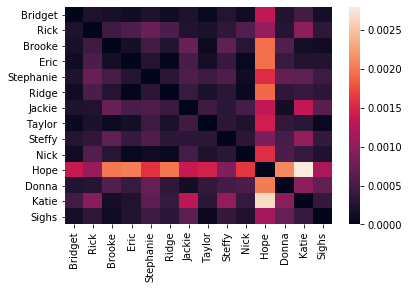

In [40]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), 
                       index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

#### Excluding some of the less interesting types of word and including only the stemized words.

In [41]:
ps = PorterStemmer()

i = 0
all_texts = []
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            target = spacy_pos(dool[i:j])
            not_interest_lst = ['UH', 'DT', 'PRP', 'MD', 'TO', 'WP', 'CD', 'CC', 'EX']
            target = [ps.stem(i) for i, j in target if j not in not_interest_lst]
            actor_network.nodes[token[2:]]['words'].append(target)
            all_texts.append(lucem_illud_2020.normalizeTokens(target))

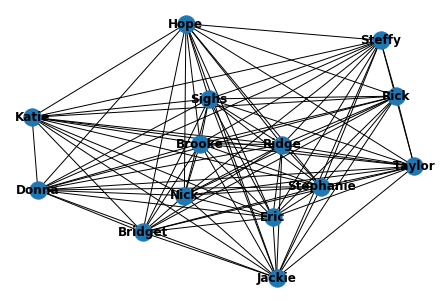

In [42]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [43]:
dictionary = gensim.corpora.Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, 
                                          num_topics=10, 
                                          alpha='auto', eta='auto')
doollda.show_topics()

[(0,
  '0.078*"hope" + 0.068*"m" + 0.037*"talk" + 0.032*"know" + 0.026*"need" + 0.025*"happi" + 0.021*"noth" + 0.020*"mean" + 0.019*"honey" + 0.018*"realli"'),
 (1,
  '0.072*"good" + 0.072*"wa" + 0.035*"hope" + 0.025*"believ" + 0.021*"night" + 0.019*"worri" + 0.017*"today" + 0.016*"littl" + 0.014*"logan" + 0.014*"think"'),
 (2,
  '0.138*"know" + 0.047*"like" + 0.045*"feel" + 0.029*"day" + 0.025*"dad" + 0.025*"think" + 0.023*"ha" + 0.021*"wa" + 0.018*"mean" + 0.017*"thing"'),
 (3,
  '0.079*"steffi" + 0.070*"right" + 0.057*"love" + 0.041*"tell" + 0.029*"know" + 0.028*"look" + 0.023*"mom" + 0.020*"marri" + 0.015*"becaus" + 0.014*"m"'),
 (4,
  '0.064*"mm" + 0.053*"think" + 0.043*"come" + 0.039*"gon" + 0.035*"mayb" + 0.031*"m" + 0.028*"hear" + 0.023*"walk" + 0.022*"leav" + 0.022*"home"'),
 (5,
  '0.035*"ridg" + 0.034*"ve" + 0.032*"get" + 0.031*"stop" + 0.026*"fine" + 0.024*"forrest" + 0.023*"thoma" + 0.023*"ask" + 0.021*"design" + 0.021*"m"'),
 (6,
  '0.068*"liam" + 0.068*"whi" + 0.039*"let

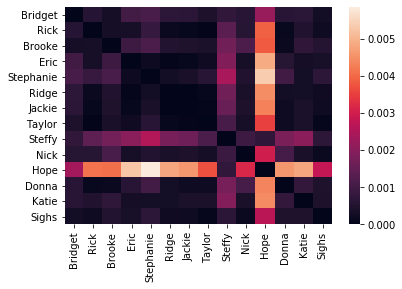

In [44]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(
        lucem_illud_2020.normalizeTokens(actor_all_words))]

L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = [topic_prob for topic_no, topic_prob in p]
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = [topic_prob for topic_no, topic_prob in q]
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), 
                       index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()